## Using LMFIT for Sequential and Global Fit of a Polymer Sample

QENS data obtained from a sample of water at room temperature.

Steps shown in this tutorial:

- Create a simple model: one elastic line, plus one Fourier transform of the stretched exponential, plus a linear background, plus a tabulated model representing the empty can.
- Interactively find an initial guess of the model parameters for the spectrum with lowest Q.
- Automatic fit the spectrum with lowest Q and visualize results.
- Automatic sequential fit of the remaining spectra and visualize results.
- Fit the Q-dependence of the relaxation time to a power law.
- Simultaneous fit of all spectra with one global parameter: stretching exponent.
- Visualize results from the simultaneous fit.

### Useful links
- [qef documentation](http://qef.readthedocs.io/en/latest/) (<code>pip install qef</code>) Utilities for QENS fitting
- [lmfit documentation](https://lmfit.github.io/lmfit-py/index.html) Curve fitting
- [matplotlib](https://matplotlib.org) Plotting with python
- [Post your questions](https://gitter.im/basisdoc/Lobby)

<a id='Table of Contents'></a><h3>Table of Contents</h3>
- <a href='#download_data'>Donwload Data</a>  
- <a href='#load_data'>Load Data and Visualize</a>  
- <a href='#def_fit_range'>Define the Fitting Range</a>  
- <a href='#def_mod'>Define the model</a>  
- <a href='#init_guess'>Obtain an initial guess</a>  
- <a href='#carry_fit_results'>Carry out the fit and look at results</a>  
- <a href='#seq_fit'>Sequential Fit</a>  
- <a href='#seq_vis'>Visualize sequential fits</a>  
- <a href='#qdep_par'>Q-dependence of some parameters</a>  
- <a href='#init_guess_teix'>Initial Guess for Teixeira Water model</a>  
- <a href='#sim_fit_model'>Model for Simultaneous Fit of All Spectra with Teixeira Water Model</a>  
- <a href='#sim_fit_vis'>Visualize the Simultaneous Fit</a>  

### Imports for fitting

In [2]:
from __future__ import (absolute_import, division, print_function)

import os
from os.path import join as pjn
import sys
import functools
import lmfit
from lmfit.models import LinearModel, LorentzianModel, ConstantModel, LinearModel

import qef
from qef.io.loaders import load_dave
from qef.models.deltadirac import DeltaDiracModel
from qef.models.tabulatedmodel import TabulatedModel
from qef.models.resolution import TabulatedResolutionModel
from qef.models.teixeira import TeixeiraWaterModel
from qef.operators.convolve import Convolve

### Imports for plotting and widgets

In [3]:
from IPython.core.display import HTML
from IPython.core.display import display
from ipywidgets import widgets

import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

(<a href='#Table of Contents'>Top</a>)<a id='download_data'></a><h3>Donwload Data</h3>

It's assumed <code>git</code> is installed in your system. Otherwise,
[follow instructions](http://qef.readthedocs.io/en/latest/installation.html#testing-tutorials-data)
to download and unpack your data to <code>/tmp/qef_data</code>

In [4]:
%%bash
qef_data_dir="/tmp/qef_data"
if [ -d ${qef_data_dir} ]; then
    cd ${qef_data_dir}
    git pull --rebase
else
    git clone https://github.com/jmborr/qef_data ${qef_data_dir}
fi

Current branch master is up to date.


In [5]:
qef_data_dir = '/tmp/qef_data'
data_dir = os.path.join(qef_data_dir, 'data', 'notebooks', 'strexp')
if not os.path.isdir(data_dir):
    raise IOError('data dir ' + data_dir + 'does not exists')
print(data_dir)

/tmp/qef_data/data/notebooks/strexp


(<a href='#Table of Contents'>Top</a>)<a id='load_data'></a><h3>Load data and visualize data</h3>

<IPython.core.display.Javascript object>


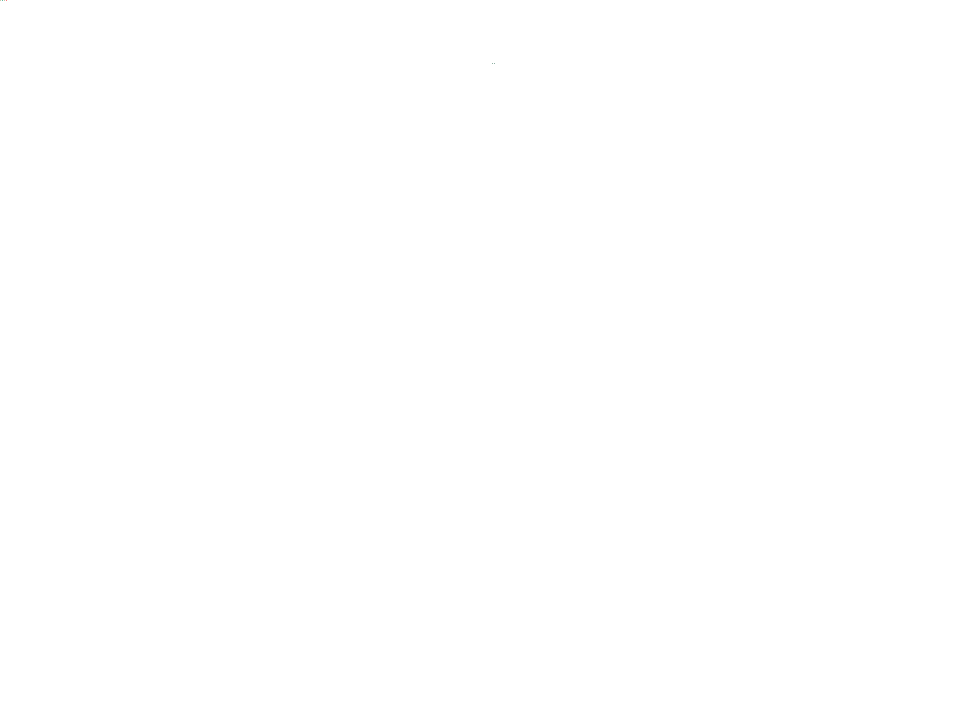

In [27]:
filenames = dict(dat='data.grp', bkg='background.grp', res='resolution.grp')
# Check files exists
for filename in filenames.values():
    full_filename = pjn(data_dir, filename)
    if not os.path.exists(full_filename):
        raise IOError('File ' + filename + ' not found in ' + data_dir)
    
res = load_dave(pjn(data_dir, 'resolution.grp'))
dat = load_dave(pjn(data_dir, 'data.grp'))
bkg = load_dave(pjn(data_dir, 'resolution.grp'))

plot_args=dict(color='black', marker='o', markersize=1, markerfacecolor='none')
f, ax = plt.subplots()
ax.scatter(res['x'], res['y'][7])
#ax.semilogy(res['x'], res['y'][7], **plot_args)
#[ax.semilogy(res['x'], spectrum) for spectrum in res['y']]; ax.set_title('resolution')
#f, (ax1, ax2, ax3) = plt.subplots(1, 3)
#[ax1.semilogy(res['x'], spectrum) for spectrum in res['y']]; ax1.set_title('resolution')
#[ax2.semilogy(dat['x'], spectrum) for spectrum in dat['y']]; ax2.set_title('sample')
#[ax3.semilogy(bkg['x'], spectrum) for spectrum in bkg['y']]; ax3.set_title('empty can')

In [9]:
res['y'][0]

array([2.07352e-03, 1.98801e-03, 2.40648e-03, 2.11926e-03, 1.94248e-03,
       2.65906e-03, 2.74229e-03, 1.97901e-03, 2.49010e-03, 1.90315e-03,
       1.90426e-03, 2.77858e-03, 2.14998e-03, 2.10387e-03, 2.36193e-03,
       2.12497e-03, 2.28415e-03, 2.49503e-03, 2.36365e-03, 2.22517e-03,
       2.27831e-03, 2.07177e-03, 2.15702e-03, 2.49062e-03, 1.97939e-03,
       2.28361e-03, 2.44326e-03, 2.23229e-03, 1.99061e-03, 1.68617e-03,
       2.28203e-03, 1.64718e-03, 2.16069e-03, 2.65759e-03, 1.88809e-03,
       2.31075e-03, 2.11627e-03, 2.24369e-03, 1.73030e-03, 1.92596e-03,
       2.78282e-03, 1.47648e-03, 2.16421e-03, 2.32116e-03, 1.98224e-03,
       2.44584e-03, 2.49590e-03, 2.73845e-03, 1.85247e-03, 1.97539e-03,
       2.03021e-03, 2.91694e-03, 2.18518e-03, 2.09944e-03, 2.32502e-03,
       2.06023e-03, 2.44385e-03, 2.66492e-03, 2.36131e-03, 2.27538e-03,
       2.02805e-03, 2.11112e-03, 3.04458e-03, 2.27854e-03, 2.19993e-03,
       2.48600e-03, 2.34966e-03, 2.78541e-03, 2.45633e-03, 2.024

In [ ]:
filenames = dict(dat='data.grp', bkg='background.grp', 'res'=resolution.grp)
# Check files exists
for filename in filenames.values():
    if not os.path.isdir(os.path.join(data_dir, filename)):
        raise IOError('File', filename, 'not found in', data_dir)
                           
res = load_nexus(pjn(data_dir,'irs26173_graphite_res.nxs'))
emin, emax = np.min(res['x']), np.max(res['x'])
dat = load_nexus(pjn(data_dir,'irs26176_graphite002_red.nxs')) # data has 10 histograms
emin, emax = min(emin, np.min(dat['x'])), max(emax, np.max(dat['x']))
print('resolution range is ({:.4f}, {:.4f})'.format(res['x'][0], res['x'][-1]))
print('data range is ({:.4f}, {:.4f})'.format(dat['x'][0], dat['x'][-1]))
qs = (0.525312757876, 0.7291668809127, 0.9233951329944, 1.105593679447, 1.273206832528, 1.42416584459, 1.556455009584, 1.668282739099, 1.758225254224, 1.825094271503)
# Plot
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.semilogy(res['x'], res['y'][0]); ax1.set_title('resolution')
[ax2.semilogy(dat['x'], data) for data in dat['y']]; ax2.set_title('sample')

(<a href='#Table of Contents'>Top</a>)<a id='def_fit_range'></a><h3>Define the Fitting Range</h3>

In [ ]:
e_min = -0.4 ; e_max = 0.4

# Find indexes of dat['x'] with values in (e_min, e_max)
mask = np.intersect1d(np.where(dat['x']>e_min), np.where(dat['x']<e_max))

# Drop data outside the fitting range
fr = dict()  # fitting range. Use in place of 'dat'
fr['x'] = dat['x'][mask]
fr['y'] = np.asarray([y[mask] for y in dat['y']])
fr['e'] = np.asarray([e[mask] for e in dat['e']])

# Plot
f, ax = plt.subplots()
[ax.semilogy(fr['x'], data) for data in fr['y']]; ax.set_title('sample')

(<a href='#Table of Contents'>Top</a>)<a id='def_mod'></a><h3>Define the model</h3>

<center>$S(E) = I \cdot R(Q,E) \otimes \big( eisf \cdot \delta(E-E_0) + (1-eisf) \cdot L(E-E_0) \big) + LB$</center>

We will use the following component models:
- ConstantModel represents one number that can be fitted
- DeltaDiracModel
- LorentzianModel has parameter $sigma \equiv HWHM$
- TabulatedResolutionModel to store the table of numbers representing the resolution
- LinearModel for the linear background

In [ ]:
# Create the Model. We put everything under a function which we'll later reuse

def generate_model_and_params(spectrum_index=None):
    r"""Produce an LMFIT model and related set of fitting parameters"""

    sp = '' if spectrum_index is None else '{}_'.format(spectrum_index)  # prefix if spectrum_index passed

    # Model components
    intensity = ConstantModel(prefix='I_'+sp)  # I_amplitude
    elastic = DeltaDiracModel(prefix='e_'+sp)  # e_amplitude, e_center
    inelastic = LorentzianModel(prefix='l_'+sp)  # l_amplitude, l_center, l_sigma (also l_fwhm, l_height)
    resolution = TabulatedResolutionModel(res['x'], res['y'], prefix='r_'+sp)  # (fixed r_amplitude, r_center)
    background = LinearModel(prefix='b_'+sp)  # b_slope, b_intercept

    # Putting it all together
    model = intensity * Convolve(resolution, elastic + inelastic) + background
    parameters = model.make_params()  # model parameters are a separate entity.

    # Ties and constraints
    parameters['e_'+sp+'amplitude'].set(min=0.0, max=1.0)
    parameters['l_'+sp+'center'].set(expr='e_'+sp+'center')  # centers tied
    parameters['l_'+sp+'amplitude'].set(expr='1 - e_'+sp+'amplitude')

    # Some initial sensible values
    init_vals = {'I_'+sp+'c': 1.0, 'e_'+sp+'amplitude': 0.5, 'l_'+sp+'sigma': 0.01,
                 'b_'+sp+'slope': 0, 'b_'+sp+'intercept': 0}
    for p, v in init_vals.items():
        parameters[p].set(value=v)

    return model, parameters

# Call the function
model, params = generate_model_and_params()

(<a href='#Table of Contents'>Top</a>)<a id='init_guess'></a><h3>Obtain an initial guess</h3>

A widget that compares the evaluation of the model with one of the experimental spectra. You can tweak only the free (unconstrained) parameters.

When run, you will see two empty panels, one for comparison between experiment and model, and the second panel for residuals. Start changing the values of the parameters for the panels to be populated.

A good initial guess for the first spectrum is :

> spectum index = 0    
> I_c = 4  
> e_center = 0  
> e_amplitude = 0.1  
> l_sigma = 0.03  
> b_intercept = 0  
> b_slope = 0  


In [ ]:
# Variables from previous cells and setting of other variables
# params
# e_vals
# model
free_params = [p for p in params.values() if not p.expr and p.vary]  # only adjust free parameters
e_vals = fr['x']
y_exp = fr['y'][0] # associated experimental values for the first histogram
e_exp = fr['e'][0]

f = plt.figure()
gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=[4, 1])
ax1 = f.add_subplot(gs[0])  # host the fit
ax2 = f.add_subplot(gs[1], sharex=ax1)  # host the residuals

#f, (ax1, ax2) = plt.subplots(2, 1)
def plot_new_spectrum(an_axis):
    global y_exp
    an_axis.clear()
    an_axis.plot(e_vals, y_exp, color='black', marker='o',
                 markersize=1.0, linewidth=0, label='experiment')
    an_axis.legend()

def plot_guess(an_axis, model_evaluation):
    plot_new_spectrum(an_axis)
    an_axis.plot(e_vals, model_evaluation, color='blue', label='model')
    an_axis.legend()

def plot_difference(an_axis, model_evaluation):
    global y_exp
    an_axis.clear()
    an_axis.plot(e_vals, y_exp - model_evaluation, color='black',
                 markersize=1.0, label='exp - model')
    an_axis.legend()

def i_histogram_changed(bunch):
    global y_exp
    y_exp = fr['y'][bunch['new']]
    global e_exp
    e_exp = fr['e'][bunch['new']]
    plot_new_spectrum(ax1)
    ax2.clear()

# Widget for the spectrum index
w_label = widgets.Label('spectrum index', layout=widgets.Layout(width='10%'))
w_int_text = widgets.BoundedIntText(value=0, min=0, max=len(dat['y']),
                                    layout=widgets.Layout(width='20%'))
w_int_text.observe(i_histogram_changed, 'value')
p_hbox_l = [widgets.HBox([w_label, w_int_text])]

def update_model(name, value, parameters):
    parameters[name].set(value=value)
    return model.eval(x=e_vals, params=parameters)

widget_to_parameter = dict()
def parameter_changed(bunch):
    w_float_text = bunch['owner']
    p_name = widget_to_parameter[w_float_text]
    value = bunch['new']
    w_float_text.step = 0.1 * value  # update the step as 10% of current value
    model_evaluation = update_model(p_name, value, params)
    plot_guess(ax1, model_evaluation)
    plot_difference(ax2, model_evaluation)
    
def p_hbox(p):
    """Generate an HBox widget for a given fitting parameter

    Parameters
    ----------
    p : lmfit parameter
    """
    w_label = widgets.Label(p.name, layout=widgets.Layout(width='10%'))
    w_float_text = widgets.FloatText(value=p.value, layout=widgets.Layout(width='20%'))
    w_float_text.step = 0.1 * p.value
    w_float_text.observe(parameter_changed, 'value')
    widget_to_parameter[w_float_text] = p.name
    return widgets.HBox([w_label, w_float_text])

p_hbox_l.extend([p_hbox(p) for p in free_params])

vertical_layout = widgets.VBox(p_hbox_l)
display(vertical_layout)

(<a href='#Table of Contents'>Top</a>)<a id='carry_fit_results'></a><h3>Carry out the fit and look at results</h3>

In [ ]:
fit = model.fit(y_exp, x=e_vals, params=params, weights = 1.0 / e_exp)
print('Chi-square =', fit.redchi)
fit.plot(data_kws=dict(color='black', marker='o', markersize=1, markerfacecolor='none'),
         fit_kws=dict(color='red', linewidth=4))
print('\n'.join('{} = {}'.format(p.name, p.value) for p in fit.params.values()))

(<a href='#Table of Contents'>Top</a>)<a id='seq_fit'></a><h3>Sequential Fit</h3>

**Special instructions:** If the fit you carried out in the previous cell was not for the first spectrum, the sequential fit will not run but raise an error. Go back to the cell for the Initial Guess and carry out a guess and a subsequent fit for the first spectrum, then come back here.

Starting from the first spectrum, we iteratively fit spectra of higher q's.

We do not assume any particular Q-dependence for the width of the Lorentzian function.

In [ ]:
n_spectra = len(fr['y'])
fits = [None,] * n_spectra  # store fits for all the tried spectra
fits[0] = fit # store previous fit
for i in range(1, n_spectra):
    y_exp = fr['y'][i]
    e_exp = fr['e'][i]
    fit = model.fit(y_exp, x=e_vals, params=params, weights = 1.0 / e_exp)
    params = fit.params  # update params with results from previous spectrum's fit
    fits[i] = fit  # store fit results

# Show Chi-square versus Q
chi2s = [fit.redchi for fit in fits]
f, ax = plt.subplots()
ax.plot(qs, [fit.redchi for fit in fits])
ax.set_xlabel('Q')
ax.set_ylabel('Chi-squared')

(<a href='#Table of Contents'>Top</a>)<a id='seq_vis'></a><h3>Visualize sequential fits</h3>


In [ ]:
sv_fig = plt.figure()
def fit_changed(bunch):
    sv_fig.clear()
    fits[bunch['new']].plot(fig=sv_fig,
                            data_kws=dict(color='black', marker='o', markersize=1, markerfacecolor='none'),
                            fit_kws=dict(color='red', linewidth=4))

# Widget for the spectrum index
sv_label = widgets.Label('spectrum index', layout=widgets.Layout(width='10%'))
sv_int_text = widgets.BoundedIntText(value=0, min=0, max=(n_spectra - 1),
                                     layout=widgets.Layout(width='20%'))
sv_int_text.observe(fit_changed, 'value')
sv_hbox_l = [widgets.HBox([sv_label, sv_int_text])]

sv_vertical_layout = widgets.VBox(sv_hbox_l)
display(sv_vertical_layout)

(<a href='#Table of Contents'>Top</a>)<a id='qdep_par'></a><h3>Q-dependence of some parameters</h3>

The sample is liquid water, thus we expect $EISF \ll 1$

In [ ]:
names = ('l_fwhm', 'e_amplitude')  # fitting parameters we want to plot
ylabels = ('FWHM', 'EISF')  # labels on the Y-axis of the plots
xlabels = ('Q^2', 'Q')  # labels on the X-axis of the plots

q_vals = np.asarray(qs)
xs = (q_vals * q_vals, q_vals)  # we want to plot FWHM versus Q^2 and EISF versus Q

f, axs = plt.subplots(1, len(names))  # as many plots as fitting parameters of interest
for i in range(len(names)):
    name = names[i]  # name of the fit parameter
    y = [fit.params[name].value for fit in fits]
    ax = axs[i]  # select appropriate plotting area
    ax.plot(xs[i], y, marker='o', linestyle='dashed')
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel(ylabels[i])

plt.tight_layout()

(<a href='#Table of Contents'>Top</a>)<a id='init_guess_teix'></a><h3>Initial Guess for Teixeira Water model</h3>

We use the previous $FWHM$ to fit $HWHM(Q^2)$ to Teixeira's water model to obtain initial diffusion $D$ and relaxation time coefficients $\tau$

<center>$HWHM = \frac{\hbar D\cdot Q^2}{1 + D \cdot Q^2 \cdot \tau}$ </center>

If $Q$ in Angstroms, $HHWM$ in $meV$, and $\hbar$ in $meV \cdot ps$, then units of $D$ are $A^2/ps$ and units of $\tau$ are $ps$.


In [ ]:
# Collect FHWM from the fits, and associated error in estimation of these optimal values.
hwhms = 0.5 * np.asarray([fit.params['l_fwhm'].value for fit in fits])  # HWHM values


# Create the model
from qef.constants import hbar  # units of meV x ps  or ueV x ns
from lmfit.model import Model

def teixeira(q2s, difcoef, tau):
    r"""Calculate HWHM for a given Q, diffusion coefficient, and relaxation time

    Parameters
    ----------
    q2s : float
        Q^2 values
    difcoef : float
        Diffusion coefficient parameter
    tau : float
        Relaxation time parameter

    Returns
    -------
    numpy.ndarray
        HWHM values
    """
    dq2 = difcoef * q2s
    return hbar * dq2 / (1 + dq2 * tau)

teixeira_model = Model(teixeira)  # create LMFIT Model instance
teixeira_model.set_param_hint('difcoef', min=0)  # diffusion coefficient must be positive
teixeira_model.set_param_hint('tau', min=0)  # relaxation coefficient must be positive


# Carry out the fit

teixeira_params = teixeira_model.make_params(difcoef=1.0, tau=1.0)  # initial guess
teixeira_fit = teixeira_model.fit(hwhms, q2s=np.square(q_vals), params=teixeira_params)

# Visualize fit results
o_p = teixeira_fit.params  # optimal parameters
fmt = 'Chi-square = {}\nD = {} A^2/ps\ntau = {} ps'
print(fmt.format(teixeira_fit.redchi, o_p['difcoef'].value, o_p['tau'].value))
teixeira_fit.plot(xlabel='Q^2', ylabel='HWHM')

(<a href='#Table of Contents'>Top</a>)<a id='sim_fit_model'></a><h3>Model for Simultaneous Fit of All Spectra with Teixeira Water Model</h3>

We impose a Q-dependende for the FWHM of the Lorentzian, given by the Teixeira water model. Parameters $D$ and $\tau$ are the only parameters that are same for all spectra.

<center>
$S(Q, E) = I \cdot R(Q,E) \otimes \big( eisf \cdot \delta(Q, E-E_0) + (1-eisf) \cdot L(Q, E-E_0, FWHM = \frac{2 \hbar D\cdot Q^2}{1 + D \cdot Q^2 \cdot \tau}) \big) + LB$
</center>

We use $D$ and $\tau$ of the previous fit as initial guesses. We use the sequential fits we did before to initialize all other parameters.

In [ ]:
# Create a model for each spectrum

#initialize models and parameter sets for each spectrum


# create one model for each spectrum, but collect all parameters under
# a single instance of the Parameters class.
l_model = list()
g_params = lmfit.Parameters()
for i in range(n_spectra):
    m, ps = generate_model_and_params(spectrum_index=i)  # model and parameters for one of the spectra
    l_model.append(m)
    [g_params.add(p) for p in ps.values()]

# Initialize parameter set with the optimized parameters from the sequential fit
for i in range(n_spectra):
    optimized_params = fits[i].params  # these are I_c, e_amplitude,...
    for name in optimized_params:
        prefix, base = name.split('_')  # for instance, 'e_amplitude' splitted into 'e', and 'amplitude'
        i_name = prefix + '_{}_'.format(i) + base  # i_name is 'e_3_amplitude' for i=3
        g_params[i_name].set(value=optimized_params[name].value)

# Introduce global parameters diff and tau. Use previous optimized values as initial guess
g_params.add('difcoef', value=o_p['difcoef'].value, min=0)
g_params.add('tau', value=o_p['tau'].value, min=0)

# Tie each lorentzian l_i_sigma to the teixeira expression
for i in range(n_spectra):
    q2 = q_vals[i] * q_vals[i]
    teixeira_expression = '{hbar}*difcoef*{q2}/(1+difcoef*{q2}*tau)'
    g_params['l_{}_sigma'.format(i)].set(expr=teixeira_expression.format(hbar=hbar, q2=q2))

print('Number of varying parameters =',len([p for p in g_params.values() if p.vary]),'!')
g_params.pretty_print()

(<a href='#Table of Contents'>Top</a>)<a id='sim_fit_carryout'></a><h3>Carry out the Simultaneous Fit</h3>

In [ ]:
def residuals(params):
    r"""Difference between model and experiment, weighted by the experimental error

    Parameters
    ----------
    params : lmfit.Parameters
        Parameters for the global model

    Returns
    -------
    numpy.ndarray
        1D array of residuals for the global model
    """
    l_residuals = list()
    for i in range(n_spectra):
        x = fr['x']  # fitting range of energies
        y = fr['y'][i]  # associated experimental intensities
        e = fr['e'][i]  # associated experimental errors
        model_evaluation = l_model[i].eval(x=x, params=params)
        l_residuals.append((model_evaluation - y) / e)
    return np.concatenate(l_residuals)

# Minimizer object using the parameter set for all models and the
# function to calculate all the residuals.
minimizer = lmfit.Minimizer(residuals, g_params)
g_fit = minimizer.minimize()

In [ ]:
print('Chi-square = {:.2f}\n'.format(g_fit.redchi))
fmt = 'D = {:.3f} A^2/ps, tau = {:.3f} ps'
#print('Before: ', fmt.format(g_fit.init_values['difcoef'], g_fit.init_values['tau']))
print('Before:   D = 0.156 A^2/ps, tau = 1.112 ps')
print('After:   ', fmt.format(g_fit.params['difcoef'].value, g_fit.params['tau'].value))
print('Teixeira: D = 0.19  A^2/ps, tau = 1.25  ps  (J. Teixeira et al., Phys. Rev. A, 31(3), 1913-947 (1985))')

(<a href='#Table of Contents'>Top</a>)<a id='sim_fit_vis'></a><h3>Visualize the Simultaneous Fit</h3>

In [ ]:
g_fig = plt.figure()
g_gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=[4, 1])
ax_fit = g_fig.add_subplot(g_gs[0])  # host the fit
ax_res = g_fig.add_subplot(g_gs[1], sharex=ax_fit)  # host the residuals

def g_fit_changed(bunch):
    i = bunch['new']
    ax_fit.clear()
    ax_fit.errorbar(fr['x'], fr['y'][i], yerr=fr['e'][i], color='black',
                    marker='o', markersize=1, markerfacecolor='none', label='data',
                    linestyle='none')
    model_evaluation = l_model[i].eval(x=fr['x'], params=g_params)
    ax_fit.plot(fr['x'], model_evaluation, color='red', linewidth=4, label='best fit')
    ax_fit.legend()
    ax_res.clear()
    ax_res.set_xlabel('Energy (meV)')
    ax_res.plot(fr['x'],  model_evaluation - fr['y'][i], color='black', label='residuals')
    ax_res.legend()

# Widget for the spectrum index
gv_label = widgets.Label('spectrum index', layout=widgets.Layout(width='10%'))
gv_int_text = widgets.BoundedIntText(value=0, min=0, max=(n_spectra - 1),
                                     layout=widgets.Layout(width='20%'))
gv_int_text.observe(g_fit_changed, 'value')
gv_hbox_l = [widgets.HBox([gv_label, gv_int_text])]

gv_vertical_layout = widgets.VBox(gv_hbox_l)
display(gv_vertical_layout)